In [1]:
!pip install rasterio geopandas shapely wandb -Uqq

     |████████████████████████████████| 19.1MB 1.5MB/s 
     |████████████████████████████████| 1.0MB 27.9MB/s 
     |████████████████████████████████| 1.8MB 20.4MB/s 
     |████████████████████████████████| 15.3MB 457kB/s 
     |████████████████████████████████| 6.5MB 12.2MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 133kB 50.9MB/s 
     |████████████████████████████████| 174kB 54.1MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 


In [2]:
from pathlib import Path
import subprocess
import glob
import math
import sys
import json
import re
import os 
import warnings
import cv2
import time
import scipy
import click
import tables as tb
import pandas as pd
import numpy as np
import skimage.draw
import rasterio
import rasterio.features
import shapely.wkt
import shapely.ops
import shapely.geometry
from numba import njit

from tqdm import tqdm #progress bars 

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [5]:
#mount my personal colabgoogle drive to this notebook. To use local files, you have to run colab from your local runtime
from google.colab import drive
drive.mount('/content/drive')

#create path object that is in your google drive 
path = Path('/content/drive/MyDrive/AOI_5') 
Path.BASE_PATH = path

img_ext = 'images'
mask_ext = 'masks'
preds_ext = 'preds' #or  localc_preds
probs_ext = 'probs' #or  localc_probs

img_dir = path/img_ext
mask_dir = path/mask_ext
preds_dir = path/preds_ext 
probs_dir = path/probs_ext 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Checking what Google Colab is offering today :)
try:
  print(torch.cuda.get_device_properties(0))
except:
  print("No CUDA device available.")

No CUDA device available.


### Find the average jaccard index on the validation set on a per pixel basis

In [ ]:
mask = rasterio.open("/content/drive/MyDrive/AOI_5/masks/RGB-PanSharpen__32.4911034_15.5225861999.png")
pred = rasterio.open("/content/drive/MyDrive/AOI_5/preds/RGB-PanSharpen__32.4911034_15.5225861999.jpg")
prob = rasterio.open("/content/drive/MyDrive/AOI_5/probs/RGB-PanSharpen__32.4911034_15.5225861999.jpg")

In [ ]:
#convert to numpy array 
mask = mask.read().squeeze()
pred = pred.read().squeeze()
prob = prob.read().squeeze()

In [ ]:
mask[mask>0] = 1  #np.unique(mask)
pred[pred>0] = 1  #np.unique(pred)

In [ ]:
#get clusters for all prediction maps
#convert those clusters to geojsons 
#match clustered polygons to label polygons using: Algorithm 2: The algorithm for greedily matching object detection outputs to ground truth labels. Thestandard  thr(Bk)  =  0.5  (Everingham  et  al.,  2010).
#from: https://arxiv.org/pdf/1409.0575v3.pdf


In [6]:
@njit
def jaccard(y,yhat):
    #y is binary mask image 
    #yhat is binary prediction map 

    #normalize to 0 and 1 
    y = y/y.max()
    yhat= yhat/yhat.max()

    #intersection over union 
    intersection = np.sum(y*yhat)
    union = np.sum(y+yhat)-intersection 
    return intersection / union, intersection, union 

jacs, intersection, union = jaccard(mask,pred)
jacs, intersection, union

NameError: ignored

In [7]:
def get_pred_map(mask_path):
    #converts a path to a mask to a path to the prediction map 
    #From: '/content/drive/MyDrive/DSC 449 Project/Train_Test_Split/masks/Test/RGB-PanSharpen__32.4858384_15.5138111999.png'
    #To: '/content/drive/MyDrive/AOI_5/preds/RGB-PanSharpen__32.4858384_15.5138111999.jpg'
    return mask_path.replace('DSC 449 Project/Train_Test_Split/masks/Test/',f'AOI_5/{preds_ext}/').replace('.png','.jpg')

In [8]:

def find_avg_jaccard(mask_files,pred_files):
    n_files = len(mask_files)
    jacs = np.zeros(n_files)
    running_inter = 0 
    running_union = 0 

    for i in range(n_files):
        #open files 
        mask_fn = m_root+mask_files[i]
        mask = rasterio.open(mask_fn)
        pred = rasterio.open(get_pred_map(mask_fn))

        #convert to numpy array of 650x650 shape
        mask = mask.read().squeeze()
        pred = pred.read().squeeze()

        # convert to between 0 and 1 
        mask[mask>0] = 1 
        pred[pred>0] = 1

        #get jaccard index 
        jacs[i], intersection, union = jaccard(mask,pred)
        running_inter += intersection if intersection > 0 else 0 
        running_union += union if union > 0 else 0 

    return jacs, running_inter / running_union

In [ ]:
m_root = "/content/drive/MyDrive/DSC 449 Project/Train_Test_Split/masks/Test/" #just the testing set
p_root = f"/content/drive/MyDrive/AOI_5/{preds_ext}/"
mask_files = sorted(os.listdir(m_root))
pred_files = sorted(os.listdir(p_root))


In [ ]:
#run jaccard on every probability in the validation set 
jacs, avg_jac = find_avg_jaccard(mask_files, pred_files) #takes ~1 min to run. openeing the google drive files is the longest step. 

In [ ]:
avg_jac

0.598849389523001

It works! That's the pixel-basis result. Now lets look at the building-level result

# Get Clusters in segmentation map  

1. Get segmentation of labeled binary mask with connected components algorithm 

In [9]:
#Helper function 
@njit
def checkDirections(img, x, y):
    #returns a list of 8-connected pixel values for the input image and coordinates 
    
    output = [] 
    
    up = (x,y-1)
    down = (x,y+1)
    left = (x-1,y)
    right = (x+1,y)
    
    upLeft = (x-1,y-1)
    upRight = (x+1,y-1)
    downLeft = (x-1,y+1)
    downRight = (x+1,y+1)
    
    directions = [up, down, left, right, upLeft, upRight, downLeft, downRight]
    
    height, width = img.shape
    
    for direction in directions: 
        if min(direction) >= 0 and direction[0] < width and direction[1] < height: #cannot have a negative coordinate
            x, y = direction
            output.append(img[y,x]) #return pixel value 
            
    return output

In [10]:
@njit
def two_pass_algo(lbl_img):
    #8 connected - label every white pixel by changing it's value to it's object ID 
    height, width = lbl_img.shape
    objId = 1 #start labeling objects in sequential order 
    objectDict = dict() #dictionary points high object ids to low object ids 

    #check to make sure the input is correct 
    if len(np.unique(lbl_img)) != 2 and lbl_img.max()!=0: 
        print('ERROR: image is not a binary mask with unique values of 0 and 255. Image had values:',np.unique(lbl_img))
        return 

    ## first pass
    for y in range(height): 
        for x in range(width): 
            if lbl_img[y,x] == 255: #then we need to label it 
                objLabels = [] 
                objLabels = checkDirections(lbl_img,x,y)
                objLabels = sorted(set([x for x in objLabels if x > 0 and x < 255])) #remove 0 and 255 values, repeat labels, and then sort in ascending order 
                
                #if we have a collision, we have to record it 
                if len(objLabels) > 0: 
                    label = objLabels[0] #get the smallest label between the collisions 
                    for altLabel in objLabels[1:]:
                        if altLabel in objectDict:
                            objectDict[altLabel] = min(label, objectDict[altLabel]) #record collision 
                        else:
                            objectDict[altLabel] = label #big label = key, small label = value. We want to rename with small label 
                    lbl_img[y,x] = label 
                    
                else: #Need to give this point a new object 
                    lbl_img[y,x] = objId #assign this point a fresh, new object id 
                    objId += 1 

    #extend the connections in objectDict
    for k, v in objectDict.items(): 
        #remember, key is big, value is small. We are searching for the smallest value that this key connects to
        while v in set(objectDict.keys()): #note that njit needs "in" to look into a set, not a tuple for some reason
            v = objectDict[v] 
        objectDict[k] = v #we can now assign the original key a direct connection to the smallest connecting value 

    ## second pass 
    #overwrite values from previous pass 
    for y in range(height): 
        for x in range(width): 
            pixelVal = lbl_img[y,x]
            if pixelVal > 0 and pixelVal in set(objectDict.keys()): 
                lbl_img[y,x] = objectDict[pixelVal] # set value to smallest object id in this connected component 

    ## Third pass 
    #rename connected componenets in consecutive number 
    objectDict = dict() 
    objId = 1 
    for name in np.unique(lbl_img):
        if name != 0:
            objectDict[name] = objId
            objId += 1 
    
    for y in range(height): 
        for x in range(width): 
            pixelVal = lbl_img[y,x]
            if pixelVal > 0 and pixelVal in set(objectDict.keys()): 
                lbl_img[y,x] = objectDict[pixelVal]

    return lbl_img

In [ ]:
fn = '/content/drive/MyDrive/AOI_5/masks/RGB-PanSharpen__32.4875934_15.5155661999.png' 
lbl_img = cv2.imread(fn,cv2.IMREAD_GRAYSCALE)
print(np.unique(lbl_img), lbl_img.shape)
lbl_img #img is a numpy array with unique values of 0 and 255 

[  0 255] (650, 650)


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [ ]:
segmented_mask = two_pass_algo(lbl_img)
np.unique(segmented_mask)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=uint8)

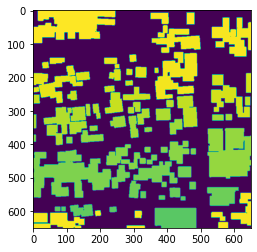

In [ ]:
#Notice the gradient for the building labels from top left to bottom right
plt.imshow(segmented_mask*255/np.max(segmented_mask))

2. Get clusters in pred with greedy algorithm in order of most confident point to least 

 a) Remove small objects below a threshold 
 
 b) Order cluster_id's in order of decreasing size 

In [11]:
@njit
def get_next_seed(img):
    height, width = img.shape #650*650 = 422,500... 
    prev_max = 0 
    max_x = 0 
    max_y = 0 
    for y in range(height):
        for x in range(width): 
            if img[y,x] < 1 and img[y,x] > prev_max: #if this point hasn't already been assigned and is greater than previous max, record coordinates 
                max_x = x 
                max_y = y 
                prev_max = img[y,x]

    return max_x, max_y

In [12]:
#label bfs and label all pixels with cluster id 
@njit
def grow_seed(img,cluster_id,origin): #note that coordinates for origin = (y,x)

    deltas = [(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1)] #all eight directions
    bfs = [origin]
    height, width = img.shape

    #start bfs 
    while bfs: 
        y, x = bfs.pop() 
        prev_val = img[y,x]
        img[y,x] = cluster_id #assign this pixel it's cluster id 

        #find connecting components 
        for dy, dx in deltas: 
            row = y + dy
            col = x + dx 
            if (row >= 0 and row < height) and (col >=0 and col < width): 
                if img[row,col] <= 1 and img[row,col] > 0:  #if unassigned point and not background point 
                    if img[row,col] <= prev_val: #make this a greedy algorithm that can't go up hill or horizontally 
                        bfs.append((row,col))  #add to fronteir 
    return img

In [13]:
@njit
def get_areas(img):
    #returns a dictionary. k=labels(pixel values) and v = pixel counts 
    height, width = img.shape
    area = dict() 

    #first pass to make an area dictionary 
    for y in range(height):
        for x in range(width): 
            pixelVal = img[y,x]
            if pixelVal > 0:
                if pixelVal not in set(area.keys()):
                    area[pixelVal] = 1
                else:
                    area[pixelVal] += 1 

    return area 

In [14]:
@njit
def rm_small_stuff(img, theta):
    #img is a numpy array with prelabeled connected components from two_pass_algo
    #remove all small connected components below threshold, theta 

    area = get_areas(img) #dictionary object connecting obj_id's to pixel areas 

    #identify small areas in this dictionary
    smallset = set()
    for k,v in area.items():
        if v <= theta: #theta is an input variable
            smallset.add(k)

    #print(smallset, area)
    #second pass to remove pixels from img 
    height, width = img.shape
    for y in range(height):
        for x in range(width): 
            pixelVal = img[y,x]
            if pixelVal in smallset:
                img[y,x] = 0 #write to img to erase this connected component 

    return img 

In [15]:
@njit
def unlabeled_cluster(img):
    #returns true or false whether there is still an unlabeled cluster in the image 
    #unlabeled clusters are identified as pixel values between 0 and 1. Values>1 are cluster_id's. 

    height, width = img.shape
    for y in range(height):
        for x in range(width): 
            pixelVal = img[y,x]
            if pixelVal > 0 and pixelVal <= 1:
                return True 

    return False 

In [16]:
@njit
def order_labels(img):

    area = get_areas(img) #dictionary object 

    #order areas in descending order 
    sorted_tuples = sorted(area.items(), key=lambda item: item[1], reverse=True) #sort by keys in descending order 

    #rename connected componenets in consecutive number 
    objectDict = dict() 
    objId = 1 #start new cluster labels at 1 
    for name, _ in sorted_tuples:
        if name != 0: 
            objectDict[name] = objId #route the old cluster label to the new one 
            objId += 1 

    height, width = img.shape
    for y in range(height): 
        for x in range(width): 
            pixelVal = img[y,x]
            if pixelVal > 0 and pixelVal in set(objectDict.keys()): 
                img[y,x] = objectDict[pixelVal]

    return img 

In [17]:
def label_preds(img_fn, resize_factor=None): 
    #input is a filename of the floating point probabilities between 0 and 1 

    #read in image
    img = cv2.imread(img_fn,cv2.IMREAD_GRAYSCALE)
    img = img/255 #probs are saved as uint8 jpg, so 0 to 255. Make that a float between 0. and 1. 

    if resize_factor:
        height, width = img.shape
        dim = (int(width * resize_factor), int(height * resize_factor))
        #resize the input  image 
        img = cv2.resize(img, dim, interpolation = cv2.INTER_LANCZOS4) #INTER_NEAREST  or INTER_AREA  or INTER_LINEAR . See which gives you the highest accuracy 

    #gaussian filter after resizing 
    img = cv2.GaussianBlur(img, (5,5), 1) #(img, (9,9), 10) # <- maybe play around with the size of this kernel 

    #remove connected components smaller than threshold 
    mask = (img > 0.5).astype(int) #make the mask 0 or 1 
    mask = (mask*255).astype(np.uint8) #make the mask 0 and 255
    mask = two_pass_algo(mask)
    mask = rm_small_stuff(mask, theta=50) # <- play around with this threshold to remove more or less noise. in a 650*650 image, 300 pixels is only 0.07% of the image... 
    mask[mask>0] = 1 #remove class labels to make this a binary mask again 

    #set all probs < 0.5 to 0, but keep everything between 0.5 and 1.0 
    img[img<=0.5] = 0 

    #apply mask to img to remove small areas from prob image
    img = img*mask # img is float between 0 and 1. mask is int between 0 annd 1. 

    #initialize cluster id
    cluster_id = 2 

    #while there's still clusters to be made 
    while unlabeled_cluster(img):
        x, y = get_next_seed(img)                       #get seed 
        img = grow_seed(img,cluster_id,origin=(y,x))    #grow seed 
        cluster_id += 1                                 #increment cluster_id

    #per ImageNet instructions, order cluster id's in terms of decreasing size 
    img = order_labels(img)

    if resize_factor:
        dim = (width, height) #dimensions of original image 
        #resize the input  image 
        img = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST) #can't interpolate on the way up b/c you need intigers

    return img 


In [18]:
fn = '/content/drive/MyDrive/AOI_5/probs/RGB-PanSharpen__32.5279584_15.5383811999.jpg' 
probs = cv2.imread(fn,cv2.IMREAD_GRAYSCALE)
probs = probs/255 #probs are saved as uint8 jpg, so 0 to 255. Make that a float between 0. and 1. 
print(np.min(probs), np.max(probs), probs.shape)
probs #img is a numpy array with floats between 0 and 1 

0.0 1.0 (650, 650)


array([[0.06666667, 0.0627451 , 0.05882353, ..., 0.25882353, 0.32156863,
        0.31372549],
       [0.05882353, 0.05490196, 0.04705882, ..., 0.24313725, 0.2745098 ,
        0.26666667],
       [0.04313725, 0.04313725, 0.03529412, ..., 0.21960784, 0.24313725,
        0.23529412],
       ...,
       [0.14509804, 0.15686275, 0.16470588, ..., 0.78039216, 0.82352941,
        0.82352941],
       [0.16862745, 0.1372549 , 0.12156863, ..., 0.81176471, 0.79607843,
        0.79607843],
       [0.18431373, 0.15686275, 0.14117647, ..., 0.82352941, 0.78039216,
        0.78039216]])

In [19]:
start = time.perf_counter()

preds = label_preds(fn,0.25)

print(time.perf_counter()-start,"seconds")
#print(np.unique(preds), preds.shape)

18.089304159000022 seconds


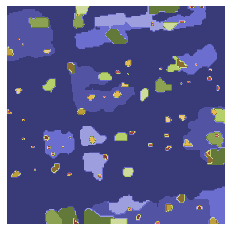

In [37]:
plt.axis('off')
plt.imshow(preds, cmap='tab20b')

In [ ]:
#simple segmentation with only the two pass algorithm and no resizing. 
fn = '/content/drive/MyDrive/AOI_5/probs/RGB-PanSharpen__32.4875934_15.5155661999.jpg'  #test image 
def simple_segment(fn):
    #no resizing. no greedy algorithm. just the two pass. 
    img = cv2.imread(fn,cv2.IMREAD_GRAYSCALE)/255
    img = cv2.GaussianBlur(img, (9,9), 10)
    mask = (img > 0.5).astype(int) #make the mask 0 or 1 
    mask = (mask*255).astype(np.uint8) #make the mask 0 and 255
    mask = two_pass_algo(mask)
    return mask 

3. Implement ImageNet Detection algorithm 

In [ ]:
def IOU(truth_map, cluster_map):
    #both inputs are labeled segmentation maps with intiger pixel values for cluseter id's 

    #normalize to 0 and 1 
    truth_map[truth_map>0] = 1 
    cluster_map[cluster_map>0] = 1 #list comprehension or double for loop if njit doesn't work... 

    #intersection over union 
    intersection = np.sum(truth_map*cluster_map)
    union = np.sum(truth_map+cluster_map)-intersection 
    return intersection / union

In [ ]:
@njit
def get_f1(true_pos, false_pos, false_neg):

    if (true_pos > 0):
        precision = float(true_pos) / (float(true_pos) + float(false_pos))
        recall = float(true_pos) / (float(true_pos) + float(false_neg))
        f1 = 2.0 * precision * recall / (precision + recall)
    else:
        f1 = 0

    return f1


In [ ]:
def get_building_acc(truth_map, pred_map):
    #inputs are segmented (labeled) building maps. buildings and clusters are list of non-zero building ids in each image in ascending order 

    threshold = 0.5 #IOU threshold to count a building as being detected or not 

    #id's of the predicted clusters 
    clusters = sorted([x for x in np.unique(pred_map) if x !=0]) #make sure it's in ascending order. Small id building preds are largest area buildings. Must go in order 
    buildings = sorted([x for x in np.unique(truth_map) if x !=0])

    pred_dict = dict() #cluster id's to building id's 
    pred_score = dict() #cluster id's to IOU score 

    true_pos =0 
    false_pos = 0
    false_neg = 0 

    #if this is an empty frame 
    if len(buildings)==0:
        false_pos = len(clusters)
        return true_pos, false_pos, false_neg

    #for each predicted building cluster 
    for cluster in clusters:
        #get the current cluster from the prediction map 
        cluster_map = pred_map.copy() #make mask
        cluster_map[cluster_map!=cluster] = 0 #mask the prediction map based on cluster id. data is the values returned 

        #find which building has the highest IOU with this cluster
        maxIOU = 0 
        max_building = None
        for building in buildings: #for each building id of the segmented truth map 
            building_map = truth_map.copy() #make mask 
            building_map[building_map!=building] = 0 
            currentIOU = IOU(building_map,cluster_map)
            if currentIOU > maxIOU:
                maxIOU = currentIOU
                max_building = building 

        if maxIOU >= threshold: #then building was detected! 
            #record the building that was detected and it's IOU 
            pred_dict[cluster] = building #k=cluster id, v=building id
            pred_score[cluster] = maxIOU 
            #remove matched building from truth map after the max IOU has been found 
            truth_map[truth_map==max_building] = 0 
            buildings.remove(max_building)
            true_pos += 1 
        else:
            false_pos += 1 #this cluster prediction didn't make the cut to detect a single building 

    #remaining buildings that have not been detected 
    false_neg = len([x for x in np.unique(truth_map) if x !=0])

    return true_pos, false_pos, false_neg

In [ ]:
#At this point we know these two algorithms work: 

## pred_map 
#with k clusters labeled from 1 to k and background 0 in descreasing size order 
prob_fn = '/content/drive/MyDrive/AOI_5/localc_probs/RGB-PanSharpen__32.4875934_15.5155661999.jpg' #input is just the file name
pred_map = label_preds(prob_fn,0.25) #reducing the image dimensions by 0.25 each gives better results. 

## truth_map
#with j clusters labeled from 1 to j and background 0 
truth_fn = '/content/drive/MyDrive/AOI_5/masks/RGB-PanSharpen__32.4875934_15.5155661999.png' 
lbl_img = cv2.imread(truth_fn,cv2.IMREAD_GRAYSCALE)
truth_map = two_pass_algo(lbl_img) #input is numpy array


In [ ]:
mask = simple_segment(prob_fn)
plt.imshow(mask)

In [ ]:
plt.axis('off')
plt.imshow(pred_map)

In [ ]:
plt.axis('off')
plt.imshow(truth_map)

In [ ]:
start = time.perf_counter()

f1 = get_building_acc(truth_map, pred_map)
print(f1)
print(time.perf_counter()-start,"seconds")

15.444434590999663 seconds


In [ ]:
get_building_acc(truth_map, mask)

0.025974025974025972

It works! and the greedy algorithm gets a better accuracy than the truth map (with probably only gets 2 out of all those buildings). 

# Get F1 score for the whole dataset 

In [ ]:
def get_prob_map(mask_path):
    #converts a path to a mask to a path to the probability map 
    return mask_path.replace('DSC 449 Project/Train_Test_Split/masks/Test/',f'AOI_5/{probs_ext}/').replace('.png','.jpg')

In [ ]:
def find_avg_f1():

    #roots to mask file directories in google drive 
    m_root = "/content/drive/MyDrive/DSC 449 Project/Train_Test_Split/masks/Test/" #just the testing set
    mask_files = sorted(os.listdir(m_root))

    n_files = len(mask_files)
    running_tp = 0
    running_fp = 0
    running_fn = 0

    #for each image in the testing set: 
    for i in tqdm(range(n_files)):
        #get file names 
        mask_fn = m_root+mask_files[i]
        pred_fn = get_prob_map(mask_fn) #func to get pred names from mask names in google drive 

        #get truth map from mask_fn
        lbl_img = cv2.imread(mask_fn, cv2.IMREAD_GRAYSCALE)
        truth_map = two_pass_algo(lbl_img) #input is numpy array

        #get pred map: input is a file name (pred_fn is the probability map of floats btw 0. and 1.)
        try:
            pred_map = label_preds(pred_fn,0.25) #<- resizing factor could be tuned 
        except:
            print(f'quit with errors')
            return
        #pred_map = simple_segment(prob_fn) #w/o greedy algo. 

        #get accuracy using ImageNet detection algorithm 
        true_pos, false_pos, false_neg = get_building_acc(truth_map, pred_map)

        #increment running totals 
        running_tp += true_pos
        running_fp += false_pos
        running_fn += false_neg

    return get_f1(running_tp, running_fp, running_fn), running_tp, running_fp, running_fn


In [ ]:
start = time.perf_counter()

print(find_avg_f1())

print(time.perf_counter()-start,"seconds") #run time depends on scaling factor 

100%|██████████| 202/202 [10:14<00:00,  3.04s/it]

(0.1700986700986701, 793, 5586, 2152)
614.4397660270006 seconds


In [ ]:
#label_preds()
#resize factor = 0.25
#IOU threshold = 0.5
#F1 = 0.18842713169516476
#832, 5054, 2113 #running_tp, running_fp, running_fn
#11 minutes to run 

In [ ]:
#label_preds()
#resize factor = 0.5
#IOU threshold = 0.5
#F1 = 0.11794807788317525
#945, 12134, 2000 #much, much more false positives. Makes sense. With less compression, we keep more of the low confidence regions. Remember, we're resizing and then blurring, which reduces the peaks on the already reduced images

In [ ]:
#simple_segment()
#IOU threshold = 0.5
#F1 = 0.07228915662650602
#606, 2626, 12928 

In [ ]:
#local contrast predictions 
#label_preds()
#resize factor = 0.25
#IOU threshold = 0.5
#F1 = 0.209
#885, 4646, 2060
#8 minutes to run 

In [ ]:
#global contrast predictions 
#label_preds()
#resize factor = 0.25
#IOU threshold = 0.5
#F1 = 0.1700986700986701
#793, 5586, 2152
